# Optimization with linear PDE

$$\min_{y,u} J(y,u) = \frac{1}{2} \|y-d\|^2 + \lambda TV(u), \\
\text{s.t. } Ay = u.$$

Here we consider the PDE is Helmholtz equation with perfectly matched layer boundary condition.

In [1]:
using PyPlot, SparseArrays, ImageFiltering

include("TV_projection.jl");

In [2]:
Nx = 101
Ny = 101
h = 0.01

c = ones(Nx, Ny)
# x = range(0,step=h,length=Nx)
# y = range(0,step=h,length=Ny)
# c = sin.(2*pi*1*x .+ 2*pi*2*y') .+ 1.5;

omega = 40

source = zeros(Nx, Ny)
# source[30:70,40:60] .= 1

radius = 20
center = [50,50]
for i = 1:Nx
    for j = 1:Ny
        if (i-center[1]).^2 + (j-center[2]).^2 < radius^2
            source[i,j] = 1
        end
    end
end
source = imfilter(source, Kernel.gaussian(5));

pml_len = 50
pml_coef = 1

1

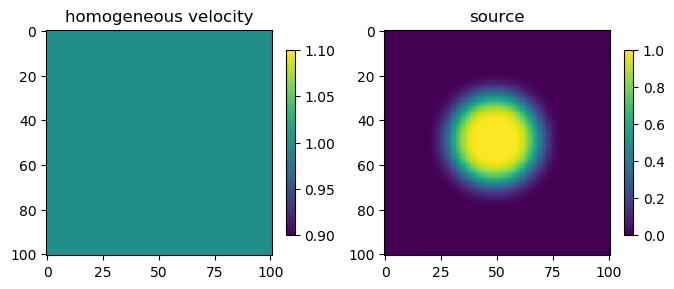

PyObject <matplotlib.colorbar.Colorbar object at 0x159e8d950>

In [3]:
figure(figsize=(8,6))
subplot(121)
imshow(c); title("homogeneous velocity"); colorbar(shrink=0.4)
subplot(122)
imshow(source); title("source"); colorbar(shrink=0.4)

In [4]:
# make diff op
Nx_pml = Nx + 2*pml_len
Ny_pml = Ny + 2*pml_len
pml_value = range(0,length=pml_len,stop=pml_coef)

beta = zeros(Nx_pml,Ny_pml);
# beta \neq 0 when PML added
for i = 1:pml_len
    beta[pml_len+1-i,:] .= pml_value[i];
    beta[end-pml_len+i,:] .= pml_value[i];
    beta[:,pml_len+1-i] .= pml_value[i];
    beta[:,end-pml_len+i] .= pml_value[i];
end

c_ex = zeros(Nx_pml,Ny_pml)
c_ex[pml_len+1:end-pml_len,pml_len+1:end-pml_len] = c
for i = 1:pml_len
    c_ex[i,:] = c_ex[pml_len+1,:];
    c_ex[end-i+1,:] = c_ex[end-pml_len,:];
    c_ex[:,i] = c_ex[:,pml_len+1];
    c_ex[:,end-i+1] = c_ex[:,end-pml_len];
end

source_ex = zeros(Nx_pml,Ny_pml)
source_ex[pml_len+1:end-pml_len,pml_len+1:end-pml_len] = source
source_ex = source_ex[:];

coef = (1 .+ im*beta) .* omega^2 ./ c_ex.^2 .- 4 ./ h^2
vec1 = ones(Nx_pml*Ny_pml-Nx_pml) ./ h^2
vec2 = ones(Nx_pml*Ny_pml-1) ./ h^2
A = spdiagm(-Nx_pml => vec1, -1 => vec2, 0 => coef[:], 1 => vec2, Nx_pml => vec1);

Compute data $d$.

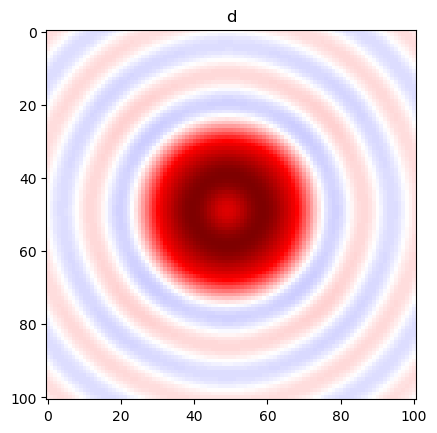

PyObject Text(0.5, 1, 'd')

In [5]:
d = A \ source_ex;

d = reshape(real(d), Nx_pml, Ny_pml);
# u = u[pml_len+1:end-pml_len, pml_len+1:end-pml_len]

imshow(d[pml_len+1:end-pml_len,pml_len+1:end-pml_len], cmap="seismic", clim=[-maximum(d),maximum(d)])
title("d")

Now compute:
$$w = \pi_K(\frac{1}{\lambda} (A^{-1})^* d) $$

$$(A^{-1})^* A^{-1} u = (A^{-1})^* d - \lambda w $$

First compute: $(A^{-1})^* d$ as A_inv_d

Then compute $g$: $g = (A^{-1})^* d - \lambda w $

Next: compute $u$: $(A^{-1})^* A^{-1} u = g $

In [6]:
function compute_g(lambda, A_inv_d; iterMax=1000)
    w_real = TV_projection_dual(real(A_inv_d), lambda; iterMax=iterMax);
    w_imag = TV_projection_dual(imag(A_inv_d), lambda; iterMax=iterMax);
    w = w_real + im.*w_imag
    g = A_inv_d - lambda * w;
    return g
end

function compute_u(g, pml_len)
    u = A * A' * g[:]
    u = real(u)
    u = reshape(u,Nx_pml,Ny_pml)
    u = u[pml_len+1:end-pml_len,pml_len+1:end-pml_len]
    return u
end

compute_u (generic function with 1 method)

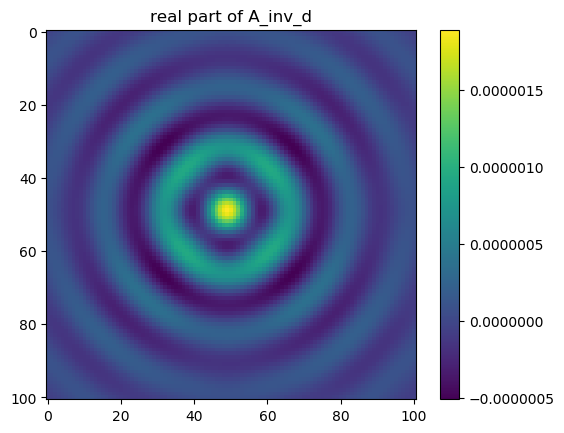

PyObject Text(0.5, 1, 'real part of A_inv_d')

In [7]:
A_inv_d = (A') \ d[:]
A_inv_d = reshape(A_inv_d, Nx_pml, Ny_pml)
imshow(real(A_inv_d[pml_len+1:end-pml_len, pml_len+1:end-pml_len])); colorbar(); title("real part of A_inv_d")

## Example 1: large $\lambda$
Notice: the iteration time is 10000, maybe very solw.
The amplitue is not right.

In [8]:
lambda1 = 1e-5
g1 = compute_g(lambda1, A_inv_d; iterMax=10000)
u1 = compute_u(g1, pml_len);

In [9]:
lambda2 = 5e-6
g2 = compute_g(lambda2, A_inv_d; iterMax=10000)
u2 = compute_u(g2, pml_len);

In [10]:
lambda3 = 1e-6
g3 = compute_g(lambda3, A_inv_d; iterMax=10000)
u3 = compute_u(g3, pml_len);

In [11]:
lambda4 = 5e-7
g4 = compute_g(lambda4, A_inv_d; iterMax=10000)
u4 = compute_u(g4, pml_len);

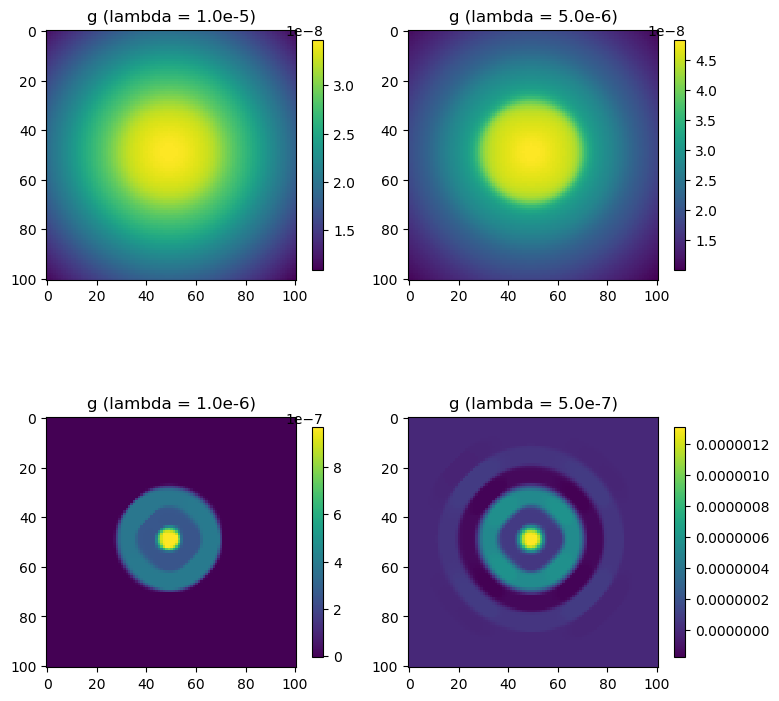

In [18]:
figure(figsize=(8,8))
subplot(221)
imshow(real(g1[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(real(g2[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(real(g3[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(real(g4[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

tight_layout()

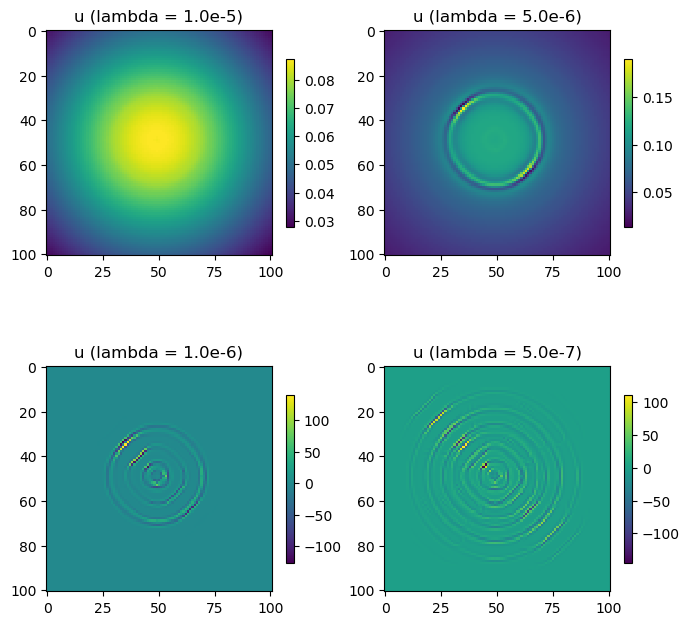

PyObject <matplotlib.colorbar.Colorbar object at 0x15e9416d0>

In [19]:
figure(figsize=(8,8))
subplot(221)
imshow(u1);
title("u (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(u2); 
title("u (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(u3); 
title("u (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(u4); 
title("u (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

## Example 2: large $\lambda$

Make $\lambda$ between 1e-6 to 5e-6. Iteration time is 1000.

In [32]:
lambda1 = 2e-6
g1 = compute_g(lambda1, A_inv_d; iterMax=1000)
u1 = compute_u(g1, pml_len);

In [35]:
lambda2 = 3e-6
g2 = compute_g(lambda2, A_inv_d; iterMax=1000)
u2 = compute_u(g2, pml_len);

In [36]:
lambda3 = 4e-6
g3 = compute_g(lambda3, A_inv_d; iterMax=1000)
u3 = compute_u(g3, pml_len);

In [37]:
lambda4 = 5e-6
g4 = compute_g(lambda4, A_inv_d; iterMax=1000)
u4 = compute_u(g4, pml_len);

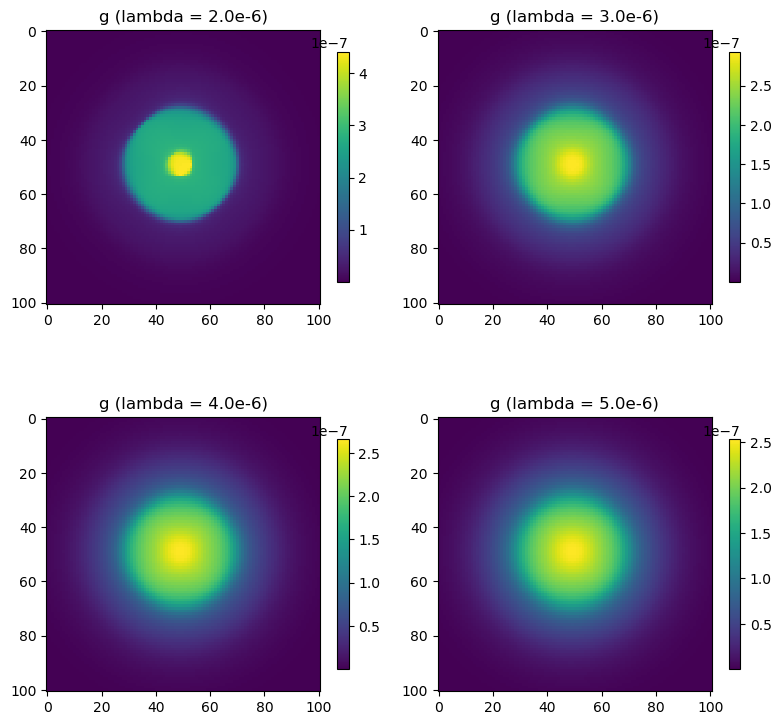

In [38]:
figure(figsize=(8,8))
subplot(221)
imshow(real(g1[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(real(g2[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(real(g3[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(real(g4[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

tight_layout()

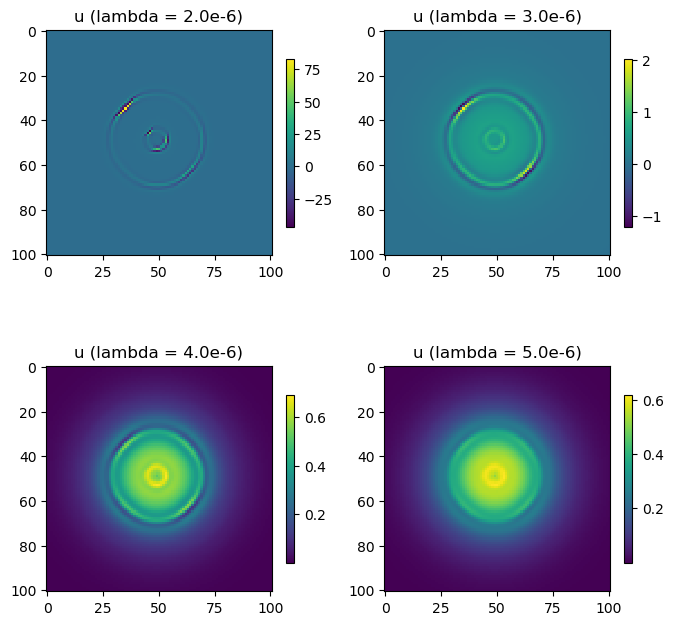

PyObject <matplotlib.colorbar.Colorbar object at 0x15cdd7c50>

In [39]:
figure(figsize=(8,8))
subplot(221)
imshow(u1);
title("u (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(u2); 
title("u (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(u3); 
title("u (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(u4); 
title("u (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

## Example 3: small $\lambda$

In [40]:
lambda1 = 1e-8
g1 = compute_g(lambda1, A_inv_d; iterMax=1000)
u1 = compute_u(g1, pml_len);

In [41]:
lambda2 = 1e-9
g2 = compute_g(lambda2, A_inv_d; iterMax=1000)
u2 = compute_u(g2, pml_len);

In [42]:
lambda3 = 1e-10
g3 = compute_g(lambda3, A_inv_d; iterMax=1000)
u3 = compute_u(g3, pml_len);

In [43]:
lambda4 = 1e-11
g4 = compute_g(lambda4, A_inv_d; iterMax=1000)
u4 = compute_u(g4, pml_len);

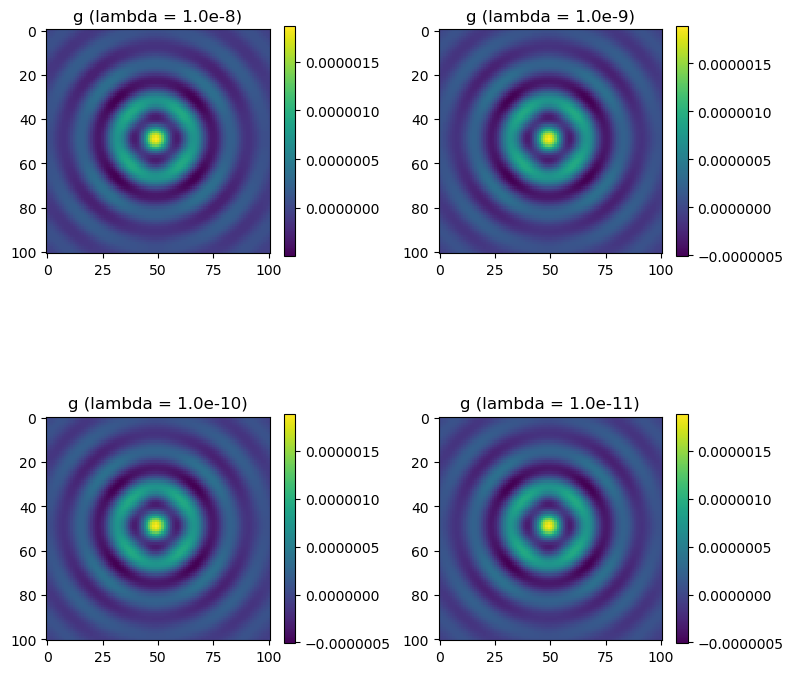

In [44]:
figure(figsize=(8,8))
subplot(221)
imshow(real(g1[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(real(g2[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(real(g3[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(real(g4[pml_len+1:end-pml_len, pml_len+1:end-pml_len]))
title("g (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

tight_layout()

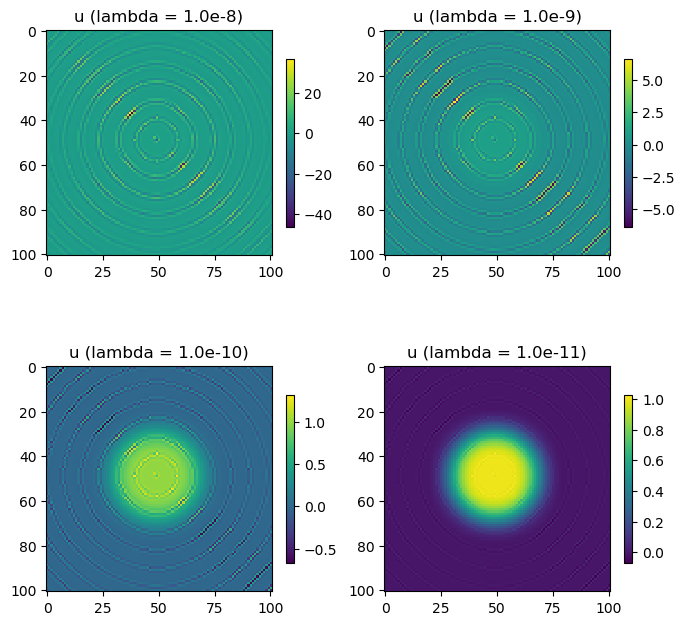

PyObject <matplotlib.colorbar.Colorbar object at 0x1628610d0>

In [45]:
figure(figsize=(8,8))
subplot(221)
imshow(u1);
title("u (lambda = " * string(lambda1) * ")"); colorbar(shrink=0.6)
subplot(222)
imshow(u2); 
title("u (lambda = " * string(lambda2) * ")"); colorbar(shrink=0.6)
subplot(223)
imshow(u3); 
title("u (lambda = " * string(lambda3) * ")"); colorbar(shrink=0.6)
subplot(224)
imshow(u4); 
title("u (lambda = " * string(lambda4) * ")"); colorbar(shrink=0.6)

## Conclusion:

- $\lambda$ plays an important role during the inverse program. Small $\lambda$ may converge to the true solution. Large $\lambda$ may change the shape.
- Iteration time is also important. It seems with large $\lambda = 5e-6$, smaller iteration is better.